In [2]:
import numpy as np
import pandas as pd
import os 
import seaborn as sns 
import matplotlib.pyplot as plt 
import typing as tp

In [3]:
from sklearn.cluster import KMeans, BisectingKMeans, AgglomerativeClustering, SpectralClustering
from sklearn.metrics import fowlkes_mallows_score, davies_bouldin_score
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_blobs, load_iris, load_wine, fetch_openml
from sklearn.preprocessing import StandardScaler

In [4]:
wine_x, wine_y = load_wine(as_frame=False, return_X_y=True)
iris_x, iris_y = load_iris(return_X_y=True)
blob_x, blob_y = make_blobs(n_samples=1_000, n_features=2, centers=5, random_state=13, center_box=(-50, 50))

In [5]:
num_wine_classes: int = np.unique(wine_y).size
num_iris_classes: int = np.unique(iris_y).size
num_blob_classes: int = np.unique(blob_y).size

num_wine_classes, num_iris_classes, num_blob_classes

(3, 3, 5)

In [6]:
wine_x[0, :], iris_x[0, :], blob_x[0, :]
# cool all of them are numerical and thus we can use the standard deviation way.

(array([1.423e+01, 1.710e+00, 2.430e+00, 1.560e+01, 1.270e+02, 2.800e+00,
        3.060e+00, 2.800e-01, 2.290e+00, 5.640e+00, 1.040e+00, 3.920e+00,
        1.065e+03]),
 array([5.1, 3.5, 1.4, 0.2]),
 array([15.15241248, 20.93095631]))

In [7]:
def category_utility(X: np.ndarray, y_pred: np.ndarray, acuity: float = 1) -> float:
    # Page 40 of Gennari, Langley, Fisher's Models of Incremental Concept Formulation
    # recommends an acuity value of 1
    # https://www.sciencedirect.com/science/article/pii/0004370289900465?ref=cra_js_challenge&fr=RR-1
    num_clusters: int = np.unique(y_pred).size

    prob_clusters: np.ndarray = np.unique(y_pred, return_counts=True)[1] / y_pred.size
    overall_feature_std: np.ndarray = X.std(axis=0)

    overall_feature_std[np.logical_or(np.isnan(overall_feature_std),
                                  np.logical_or(np.isinf(overall_feature_std), overall_feature_std <= 0))] = acuity
    inv_overall_feature_std: np.ndarray = 1 / overall_feature_std
    inv_overall_feature_std[overall_feature_std <= acuity] = acuity

    norm: float = 1 / np.sqrt(np.pi)

    cluster_cu: np.ndarray = np.zeros((num_clusters,))

    for k in range(num_clusters):
        prob_cluster_k: float = prob_clusters[k]

        cluster_k: np.ndarray = X[y_pred == k, :]

        conditional_feature_std: np.ndarray = cluster_k.std(axis=0)

        conditional_feature_std[np.logical_or(np.isnan(conditional_feature_std),
                                          np.logical_or(np.isinf(conditional_feature_std),
                                                        conditional_feature_std <= 0))] = acuity

        inv_conditional_feature_std: np.ndarray = 1 / conditional_feature_std
        inv_conditional_feature_std[conditional_feature_std <= acuity] = acuity


        diff_std: np.ndarray = np.abs(inv_overall_feature_std - inv_conditional_feature_std)

        cluster_cu[k] = prob_cluster_k * norm * np.sum(diff_std)

    overall_category_utility: float =  1 / num_clusters * np.sum(cluster_cu)
    return overall_category_utility

In [8]:
def create_kmeans_model(num_clusters: int) -> KMeans:
    return KMeans(n_clusters=num_clusters, init='k-means++', random_state=13)

def create_spectral_model(num_clusters: int) -> SpectralClustering:
    return SpectralClustering(n_clusters=num_clusters, random_state=13, assign_labels='cluster_qr', eigen_solver='amg', n_jobs=2)

def create_agglomerative_model(num_clusters: int) -> AgglomerativeClustering:
    return AgglomerativeClustering(n_clusters=num_clusters)

def create_bisect_kmeans_model(num_clusters: int) -> BisectingKMeans:
    return BisectingKMeans(n_clusters=num_clusters, random_state=13, bisecting_strategy='largest_cluster')

In [9]:
MAX_CLUSTERS: int = 20

datasets: tp.List[tp.Tuple[str, int, np.ndarray, np.ndarray]] = [('Wine', num_wine_classes, wine_x, wine_y), ('Iris', num_iris_classes, iris_x, iris_y), ('Blobs', num_blob_classes, blob_x, blob_y)]

models: tp.List[tp.Tuple[str, tp.Any]] = [('K-Means++' ,create_kmeans_model), ('Spectral', create_spectral_model), ('Agglomerative', create_agglomerative_model), ('Bisecting K-Means', create_bisect_kmeans_model)]

results_dl: tp.List[tp.Dict[str, tp.Union[float, str, int]]] = []

for model_name, model_function in models:
    for dataset_name, dataset_classes, x, y in datasets:

        for k in range(2, MAX_CLUSTERS):
            model = model_function(k)

            print(f'Trying out {dataset_name} with a {model_name} model...')

            # std_scaler: StandardScaler = StandardScaler()
            # scaled_x: np.ndarray = std_scaler.fit_transform(x)

            y_pred: np.ndarray = model.fit_predict(x)

            print('Getting scores')
            fm_score: float = fowlkes_mallows_score(y, y_pred)
            db_score: float = davies_bouldin_score(x, y_pred)

            print('Getting cu')
            cu: float = category_utility(x, y_pred) #  category_utility(X_test, y_pred, k)

            results_dl.append({'model_name': model_name, 'dataset_name': dataset_name, 'num_clusters': k, 'true_num_clusters': dataset_classes, 'fowlkes_mallows_score': fm_score, 'davies_bouldin_score': db_score, 'category_utility': cu})

results_df: pd.DataFrame = pd.DataFrame.from_records(results_dl)
results_df['matches_clusters'] = results_df['num_clusters'] == results_df['true_num_clusters']
results_df

Trying out Wine with a K-Means++ model...
Getting scores
Getting cu
Trying out Wine with a K-Means++ model...
Getting scores
Getting cu
Trying out Wine with a K-Means++ model...
Getting scores
Getting cu
Trying out Wine with a K-Means++ model...
Getting scores
Getting cu
Trying out Wine with a K-Means++ model...
Getting scores
Getting cu
Trying out Wine with a K-Means++ model...
Getting scores
Getting cu
Trying out Wine with a K-Means++ model...
Getting scores
Getting cu
Trying out Wine with a K-Means++ model...
Getting scores
Getting cu
Trying out Wine with a K-Means++ model...
Getting scores
Getting cu
Trying out Wine with a K-Means++ model...
Getting scores
Getting cu
Trying out Wine with a K-Means++ model...
Getting scores
Getting cu
Trying out Wine with a K-Means++ model...
Getting scores
Getting cu
Trying out Wine with a K-Means++ model...
Getting scores
Getting cu
Trying out Wine with a K-Means++ model...
Getting scores
Getting cu
Trying out Wine with a K-Means++ model...
Gettin

/home/duke_trystan/miniconda3/envs/EnablingAISystems/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:259: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


Getting scores
Getting cu
Trying out Wine with a Spectral model...


/home/duke_trystan/miniconda3/envs/EnablingAISystems/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:259: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


Getting scores
Getting cu
Trying out Wine with a Spectral model...


/home/duke_trystan/miniconda3/envs/EnablingAISystems/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:259: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


Getting scores
Getting cu
Trying out Wine with a Spectral model...
Getting scores
Getting cu
Trying out Wine with a Spectral model...
Getting scores
Getting cu
Trying out Wine with a Spectral model...
Getting scores
Getting cu
Trying out Wine with a Spectral model...
Getting scores
Getting cu
Trying out Wine with a Spectral model...
Getting scores
Getting cu
Trying out Wine with a Spectral model...
Getting scores
Getting cu
Trying out Wine with a Spectral model...
Getting scores
Getting cu
Trying out Wine with a Spectral model...
Getting scores
Getting cu
Trying out Wine with a Spectral model...
Getting scores
Getting cu
Trying out Wine with a Spectral model...
Getting scores
Getting cu
Trying out Wine with a Spectral model...
Getting scores


/home/duke_trystan/miniconda3/envs/EnablingAISystems/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:259: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
/home/duke_trystan/miniconda3/envs/EnablingAISystems/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:259: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
/home/duke_trystan/miniconda3/envs/EnablingAISystems/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:259: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
/home/duke_trystan/miniconda3/envs/EnablingAISystems/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:259: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
/home/duke_trystan/miniconda3/envs/EnablingAISystems/lib/python3.10/site

Getting cu
Trying out Wine with a Spectral model...
Getting scores
Getting cu
Trying out Wine with a Spectral model...
Getting scores
Getting cu
Trying out Wine with a Spectral model...
Getting scores
Getting cu
Trying out Wine with a Spectral model...
Getting scores
Getting cu
Trying out Iris with a Spectral model...
Getting scores
Getting cu
Trying out Iris with a Spectral model...
Getting scores
Getting cu
Trying out Iris with a Spectral model...
Getting scores
Getting cu
Trying out Iris with a Spectral model...
Getting scores
Getting cu
Trying out Iris with a Spectral model...
Getting scores
Getting cu
Trying out Iris with a Spectral model...
Getting scores
Getting cu
Trying out Iris with a Spectral model...
Getting scores
Getting cu
Trying out Iris with a Spectral model...
Getting scores
Getting cu
Trying out Iris with a Spectral model...
Getting scores


/home/duke_trystan/miniconda3/envs/EnablingAISystems/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:259: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
/home/duke_trystan/miniconda3/envs/EnablingAISystems/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:259: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
/home/duke_trystan/miniconda3/envs/EnablingAISystems/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:259: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
/home/duke_trystan/miniconda3/envs/EnablingAISystems/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:259: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
/home/duke_trystan/miniconda3/envs/EnablingAISystems/lib/python3.10/site

Getting cu
Trying out Iris with a Spectral model...
Getting scores
Getting cu
Trying out Iris with a Spectral model...
Getting scores
Getting cu
Trying out Iris with a Spectral model...
Getting scores
Getting cu
Trying out Iris with a Spectral model...
Getting scores
Getting cu
Trying out Iris with a Spectral model...
Getting scores
Getting cu
Trying out Iris with a Spectral model...
Getting scores
Getting cu
Trying out Iris with a Spectral model...
Getting scores
Getting cu
Trying out Iris with a Spectral model...
Getting scores
Getting cu
Trying out Iris with a Spectral model...
Getting scores
Getting cu
Trying out Blobs with a Spectral model...


/home/duke_trystan/miniconda3/envs/EnablingAISystems/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:259: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
/home/duke_trystan/miniconda3/envs/EnablingAISystems/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:259: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


Getting scores
Getting cu
Trying out Blobs with a Spectral model...
Getting scores
Getting cu
Trying out Blobs with a Spectral model...


/home/duke_trystan/miniconda3/envs/EnablingAISystems/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:259: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
/home/duke_trystan/miniconda3/envs/EnablingAISystems/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:259: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


Getting scores
Getting cu
Trying out Blobs with a Spectral model...
Getting scores
Getting cu
Trying out Blobs with a Spectral model...


/home/duke_trystan/miniconda3/envs/EnablingAISystems/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:259: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


Getting scores
Getting cu
Trying out Blobs with a Spectral model...


/home/duke_trystan/miniconda3/envs/EnablingAISystems/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:259: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


Getting scores
Getting cu
Trying out Blobs with a Spectral model...
Getting scores
Getting cu
Trying out Blobs with a Spectral model...


/home/duke_trystan/miniconda3/envs/EnablingAISystems/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:259: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
/home/duke_trystan/miniconda3/envs/EnablingAISystems/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:259: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


Getting scores
Getting cu
Trying out Blobs with a Spectral model...
Getting scores
Getting cu
Trying out Blobs with a Spectral model...


/home/duke_trystan/miniconda3/envs/EnablingAISystems/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:259: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
/home/duke_trystan/miniconda3/envs/EnablingAISystems/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:259: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


Getting scores
Getting cu
Trying out Blobs with a Spectral model...
Getting scores
Getting cu
Trying out Blobs with a Spectral model...


/home/duke_trystan/miniconda3/envs/EnablingAISystems/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:259: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
/home/duke_trystan/miniconda3/envs/EnablingAISystems/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:259: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


Getting scores
Getting cu
Trying out Blobs with a Spectral model...
Getting scores
Getting cu
Trying out Blobs with a Spectral model...


/home/duke_trystan/miniconda3/envs/EnablingAISystems/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:259: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
/home/duke_trystan/miniconda3/envs/EnablingAISystems/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:259: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


Getting scores
Getting cu
Trying out Blobs with a Spectral model...
Getting scores
Getting cu


/home/duke_trystan/miniconda3/envs/EnablingAISystems/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:259: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
/home/duke_trystan/miniconda3/envs/EnablingAISystems/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:259: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


Trying out Blobs with a Spectral model...
Getting scores
Getting cu
Trying out Blobs with a Spectral model...


/home/duke_trystan/miniconda3/envs/EnablingAISystems/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:259: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
/home/duke_trystan/miniconda3/envs/EnablingAISystems/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:259: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


Getting scores
Getting cu
Trying out Blobs with a Spectral model...
Getting scores
Getting cu
Trying out Wine with a Agglomerative model...
Getting scores
Getting cu
Trying out Wine with a Agglomerative model...
Getting scores
Getting cu
Trying out Wine with a Agglomerative model...
Getting scores
Getting cu
Trying out Wine with a Agglomerative model...
Getting scores
Getting cu
Trying out Wine with a Agglomerative model...
Getting scores
Getting cu
Trying out Wine with a Agglomerative model...
Getting scores
Getting cu
Trying out Wine with a Agglomerative model...
Getting scores
Getting cu
Trying out Wine with a Agglomerative model...
Getting scores
Getting cu
Trying out Wine with a Agglomerative model...
Getting scores
Getting cu
Trying out Wine with a Agglomerative model...
Getting scores
Getting cu
Trying out Wine with a Agglomerative model...
Getting scores
Getting cu
Trying out Wine with a Agglomerative model...
Getting scores
Getting cu
Trying out Wine with a Agglomerative model

,model_name,dataset_name,num_clusters,true_num_clusters,fowlkes_mallows_score,davies_bouldin_score,category_utility,matches_clusters
0,K-Means++,Wine,2,3,0.659051,0.478784,0.070879,False
1,K-Means++,Wine,3,3,0.583537,0.534243,0.050983,True
2,K-Means++,Wine,4,3,0.516389,0.544401,0.043712,False
3,K-Means++,Wine,5,3,0.508708,0.545047,0.037230,False
4,K-Means++,Wine,6,3,0.491180,0.465807,0.033530,False
...,...,...,...,...,...,...,...,...
211,Bisecting K-Means,Blobs,15,5,0.601673,0.975911,0.070799,False
212,Bisecting K-Means,Blobs,16,5,0.581334,0.968748,0.066374,False
213,Bisecting K-Means,Blobs,17,5,0.560635,0.966526,0.062470,False
214,Bisecting K-Means,Blobs,18,5,0.540314,0.957308,0.058999,False


In [10]:
results_df.describe()

,num_clusters,true_num_clusters,fowlkes_mallows_score,davies_bouldin_score,category_utility
count,216.000000,216.000000,216.000000,216.000000,216.000000
mean,10.500000,3.666667,0.541377,3.015569,0.055949
std,5.200179,0.944999,0.197606,10.395788,0.049151
min,2.000000,3.000000,0.194054,0.124593,0.009048
25%,6.000000,3.000000,0.395259,0.553781,0.020670
50%,10.500000,3.000000,0.541840,0.936237,0.034767
75%,15.000000,5.000000,0.664232,1.082644,0.075885
max,19.000000,5.000000,1.000000,124.197551,0.211386


In [11]:
results_df.to_csv(os.path.join('.', 'model_results.csv'))

In [12]:
results_df.groupby(['model_name', 'dataset_name', 'matches_clusters']).aggregate({'category_utility': ['max', 'min'], 'fowlkes_mallows_score': ['max', 'min']})

category_utility            \
                                                             max       min   
model_name        dataset_name matches_clusters                              
Agglomerative     Blobs        False                    0.200103  0.023348   
                               True                     0.211386  0.211386   
                  Iris         False                    0.121759  0.012817   
                               True                     0.081173  0.081173   
                  Wine         False                    0.067039  0.019502   
                               True                     0.049434  0.049434   
Bisecting K-Means Blobs        False                    0.200103  0.023348   
                               True                     0.211386  0.211386   
                  Iris         False                    0.121759  0.012817   
                               True                     0.081173  0.081173   
                  Wine         False                    0.070879  0.020370   
                               True                     0.049919  0.049919   
K-Means++         Blobs        False                    0.200103  0.023348   
                               True                     0.211386  0.211386   
                  Iris         False                    0.121759  0.012817   
                               True                     0.081173  0.081173   
                  Wine         False                    0.070879  0.018306   
                               True                     0.050983  0.050983   
Spectral          Blobs        False                    0.177034  0.023348   
                               True                     0.211386  0.211386   
                  Iris         False                    0.121759  0.012817   
                               True                     0.081173  0.081173   
                  Wine         False                    0.039855  0.009048   
                               True                     0.022581  0.022581   

                                                fowlkes_mallows_score  \
                                                                  max   
model_name        dataset_name matches_clusters                         
Agglomerative     Blobs        False                         0.949313   
                               True                          1.000000   
                  Iris         False                         0.771454   
                               True                          0.822170   
                  Wine         False                         0.644682   
                               True                          0.582122   
Bisecting K-Means Blobs        False                         0.948440   
                               True                          1.000000   
                  Iris         False                         0.756427   
                               True                          0.787562   
                  Wine         False                         0.659051   
                               True                          0.600405   
K-Means++         Blobs        False                         0.948609   
                               True                          1.000000   
                  Iris         False                         0.756593   
                               True                          0.820808   
                  Wine         False                         0.659051   
                               True                          0.583537   
Spectral          Blobs        False                         0.948503   
                               True                          1.000000   
                  Iris         False                         0.771454   
                               True                          0.829449   
                  Wine         False                         0.562525   
                               True        

<AxesSubplot:xlabel='model_name', ylabel='category_utility'>

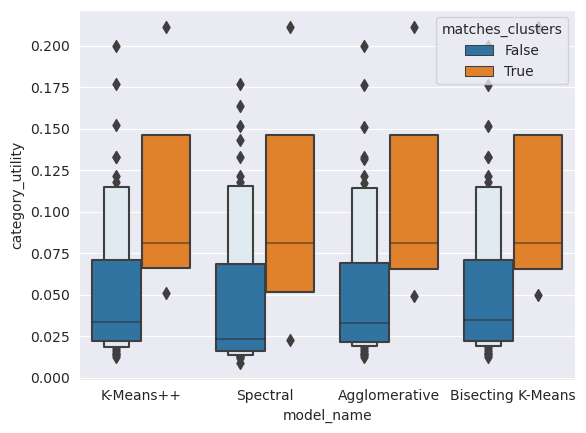

In [13]:
sns.boxenplot(data=results_df, x='model_name', y='category_utility', hue='matches_clusters')

<AxesSubplot:xlabel='model_name', ylabel='fowlkes_mallows_score'>

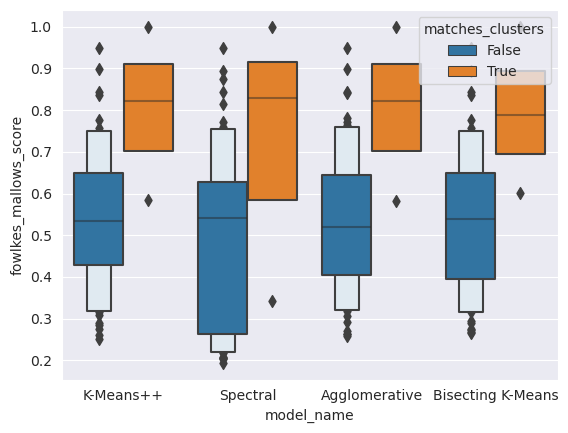

In [14]:
sns.boxenplot(data=results_df, x='model_name', y='fowlkes_mallows_score', hue='matches_clusters')

<AxesSubplot:xlabel='model_name', ylabel='davies_bouldin_score'>

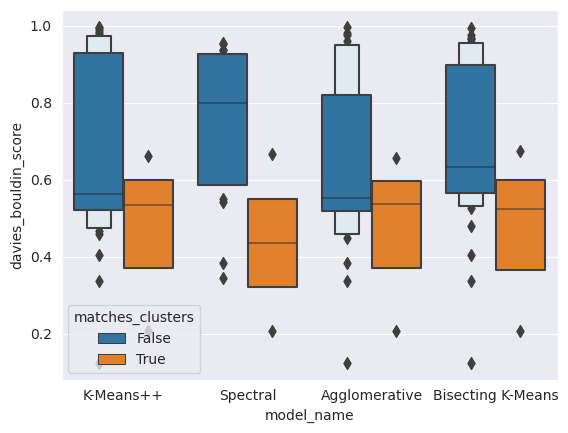

In [15]:
sns.boxenplot(data=results_df[results_df['davies_bouldin_score'] < 1], x='model_name', y='davies_bouldin_score', hue='matches_clusters')

So while category utility won't always predict the best number of clusters, the other metrics won't either

In [16]:
def compare_metrics(base_df: pd.DataFrame, metric_name: str) -> pd.DataFrame:
    grouped_comparison_df: pd.DataFrame = (base_df.groupby(['model_name', 'dataset_name', 'matches_clusters'], as_index=True)
                                           .aggregate({metric_name: lambda g: g.values.tolist()}, axis=0)
                                           .explode(metric_name, ignore_index=False))
    model_dataset_index: pd.MultiIndex = grouped_comparison_df.index.droplevel('matches_clusters').drop_duplicates()

    comparison_dl: tp.List[tp.Dict[str, tp.Any]] = []

    for model_name, dataset_name in model_dataset_index:
        mismatch_clusters: pd.Series = grouped_comparison_df.loc[(model_name, dataset_name, False), metric_name].copy()
        matched_clusters_metric: float = grouped_comparison_df.loc[(model_name, dataset_name, True), metric_name].values.item()

        num_better_mismatched: int = (mismatch_clusters > matched_clusters_metric).sum()

        # Store the model and dataset
        # The total num's + 1 is for when the clusters matched.
        # num_better is for the number of times the model got a better metric with the wrong number of clusters than
        # the metric with the correct number of clusters.
        comparison_dl.append({'model': model_name, 'dataset': dataset_name, 'total_num': mismatch_clusters.size + 1, 'num_better': num_better_mismatched})

    comparison_df: pd.DataFrame = pd.DataFrame.from_records(comparison_dl)
    return comparison_df

In [17]:
category_utility_comparison_df: pd.DataFrame = compare_metrics(results_df, 'category_utility')
# : db_score,
fowlkes_mallows_comparison_df: pd.DataFrame = compare_metrics(results_df, 'fowlkes_mallows_score')
davies_bouldin_comparison_df: pd.DataFrame = compare_metrics(results_df, 'davies_bouldin_score')
davies_bouldin_comparison_df['num_better'] = davies_bouldin_comparison_df['total_num'] - davies_bouldin_comparison_df['num_better']

/tmp/ipykernel_51058/2129213908.py:20: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


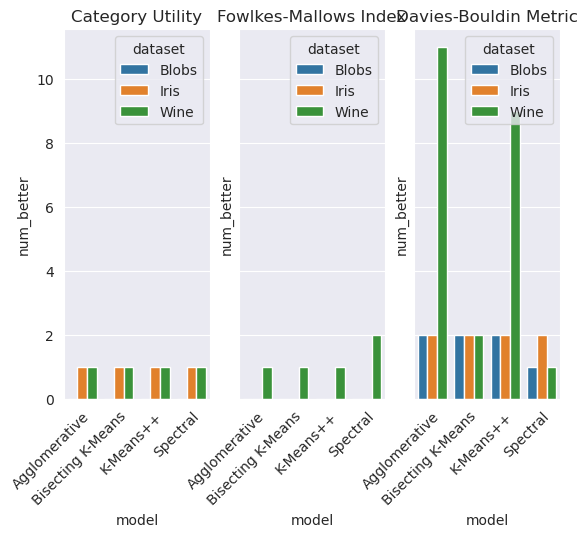

In [18]:
fig, axes = plt.subplots(1, 3, sharey=True)

# fig.title(f'Comparison of Metrics | Number of Mismatched # of Clusters')

sns.barplot(data=category_utility_comparison_df, x='model', y='num_better', hue='dataset', ax=axes[0])
axes[0].set_title('Category Utility')
plt.setp(axes[0].get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")

sns.barplot(data=fowlkes_mallows_comparison_df, x='model', y='num_better', hue='dataset', ax=axes[1])
axes[1].set_title('Fowlkes-Mallows Index')
plt.setp(axes[1].get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")

sns.barplot(data=davies_bouldin_comparison_df, x='model', y='num_better', hue='dataset', ax=axes[2])
axes[2].set_title('Davies-Bouldin Metric')
plt.setp(axes[2].get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")

fig.show()

<AxesSubplot:xlabel='model', ylabel='num_better'>

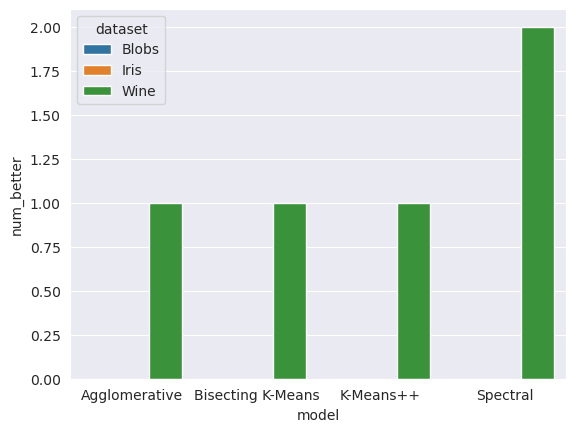

In [19]:
# Davies-Bouldin measures the classic clustering goal -
# everything within a cluster tightly knit and all of them are
# separated from each other.
sns.barplot(data=davies_bouldin_comparison_df, x='model', y='num_better', hue='dataset')

<AxesSubplot:xlabel='model', ylabel='num_better'>

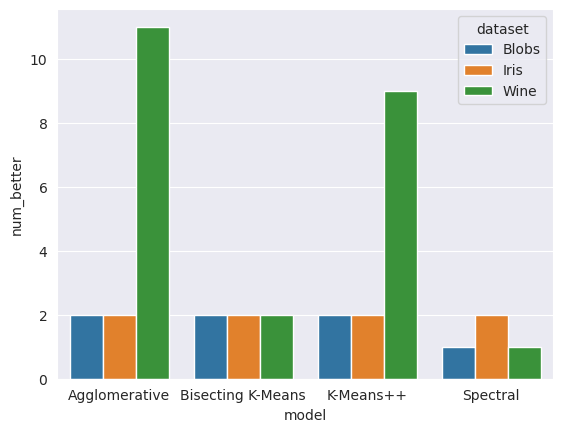

In [20]:
sns.scatterplot(x=blob_x[:, 0], y=blob_x[:, 1], hue=blob_y)

<AxesSubplot:>

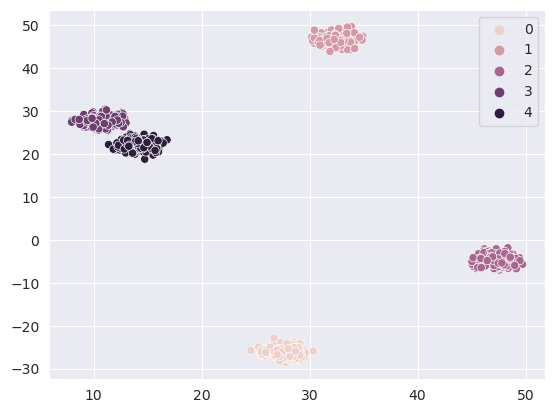

In [21]:
np.unique(blob_y)

In [22]:
blob_x.shape

array([0, 1, 2, 3, 4])

(1000, 2)

## Main algorithm

In [24]:
alg_df: pd.DataFrame = pd.read_csv(os.path.join('.', 'alg_results.csv'))
alg_df

,category_utility_recommendation,category_utility_score,category_utility_converged,fowlkes_mallows_recommendation,fowlkes_mallows_score,fowlkes_mallows_converged,davies_bouldin_recommendation,davies_bouldin_score,davies_bouldin_converged,dataset_name,model_name,true_num_classes
0,3,0.070879,True,3,0.659051,True,3,0.478784,True,Wine,K-Means++,3
1,4,0.022581,True,3,0.562525,True,4,6.848330,True,Wine,Spectral,3
2,3,0.067039,True,3,0.644682,True,3,0.458617,True,Wine,Agglomerative,3
3,3,0.070879,True,3,0.659051,True,3,0.478784,True,Wine,Bisecting K-Means,3
4,3,0.121759,True,4,0.820808,True,4,0.404293,True,Iris,K-Means++,3
5,3,0.121759,True,4,0.829449,True,4,0.382753,True,Iris,Spectral,3
6,3,0.121759,True,4,0.822170,True,4,0.382753,True,Iris,Agglomerative,3
7,3,0.121759,True,4,0.787562,True,4,0.404293,True,Iris,Bisecting K-Means,3
8,6,0.211386,True,6,1.000000,True,6,0.124593,True,Blobs,K-Means++,5
9,6,0.211386,True,6,1.000000,True,6,0.205962,True,Blobs,Spectral,5


In [25]:
cluster_utility_alg_df: pd.DataFrame = alg_df[['category_utility_recommendation', 'category_utility_score', 'category_utility_converged', 'model_name', 'dataset_name', 'true_num_classes']].rename({'category_utility_recommendation': 'recommended_classifications', 'category_utility_score': 'score', 'category_utility_converged': 'did_converge'}, axis=1)
cluster_utility_alg_df['metric_name'] = 'category_utility'

fmi_alg_df: pd.DataFrame = alg_df[['fowlkes_mallows_recommendation', 'fowlkes_mallows_score', 'fowlkes_mallows_converged', 'model_name', 'dataset_name', 'true_num_classes']].rename({'fowlkes_mallows_recommendation': 'recommended_classifications', 'fowlkes_mallows_score': 'score', 'fowlkes_mallows_converged': 'did_converge'}, axis=1)
fmi_alg_df['metric_name'] = 'fowlkes_mallows'

db_alg_df: pd.DataFrame = alg_df[['davies_bouldin_recommendation', 'davies_bouldin_score', 'davies_bouldin_converged', 'model_name', 'dataset_name', 'true_num_classes']].rename({'davies_bouldin_recommendation': 'recommended_classifications', 'davies_bouldin_score': 'score', 'davies_bouldin_converged': 'did_converge'}, axis=1)
db_alg_df['metric_name'] = 'davies_bouldin'

comp_alg_df: pd.DataFrame = pd.concat([cluster_utility_alg_df, fmi_alg_df, db_alg_df], ignore_index=True)
comp_alg_df['is_correct'] = comp_alg_df['recommended_classifications'] == comp_alg_df['true_num_classes']

comp_alg_df

,recommended_classifications,score,did_converge,model_name,dataset_name,true_num_classes,metric_name,is_correct
0,3,0.070879,True,K-Means++,Wine,3,category_utility,True
1,4,0.022581,True,Spectral,Wine,3,category_utility,False
2,3,0.067039,True,Agglomerative,Wine,3,category_utility,True
3,3,0.070879,True,Bisecting K-Means,Wine,3,category_utility,True
4,3,0.121759,True,K-Means++,Iris,3,category_utility,True
5,3,0.121759,True,Spectral,Iris,3,category_utility,True
6,3,0.121759,True,Agglomerative,Iris,3,category_utility,True
7,3,0.121759,True,Bisecting K-Means,Iris,3,category_utility,True
8,6,0.211386,True,K-Means++,Blobs,5,category_utility,False
9,6,0.211386,True,Spectral,Blobs,5,category_utility,False


Text(0.5, 1.0, 'Did All Metrics Converge?')

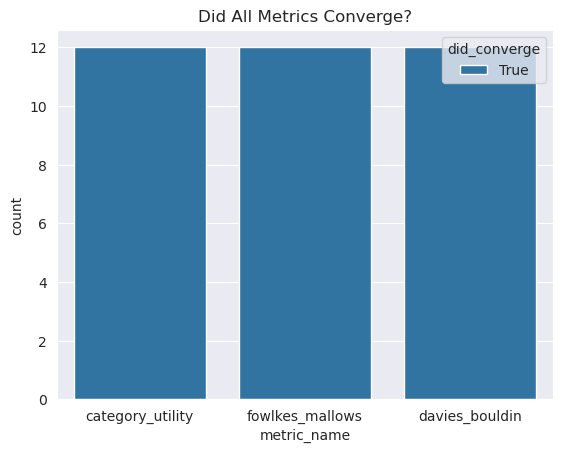

In [29]:
sns.countplot(data=comp_alg_df, x='metric_name', hue='did_converge')
plt.title('Did All Metrics Converge?')

Text(0.5, 1.0, 'How Often Were Metrics Correct?')

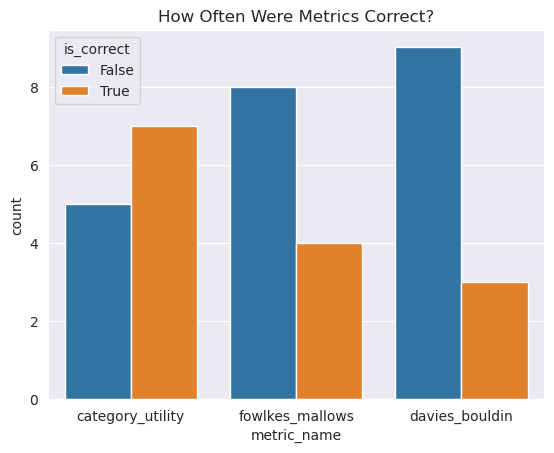

In [30]:
sns.countplot(data=comp_alg_df, x='metric_name', hue='is_correct')
plt.title('How Often Were Metrics Correct?')